### This uses PyCaret to test different models on the dataset.

In [37]:
import seaborn as sns
import pandas as pd

A function for examining model metrics

Read in the dataset.

In [38]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_400-1800.csv")
#df = pd.read_csv("../../data/scaled_and_noise_removal.csv")
#pivoted_df = pd.read_csv("../../data/Unscaled_Baseline_Correction.csv")
#pivoted_df = pd.read_csv("../../data/Scaled_Baseline_Correction.csv")
#df = pd.read_csv("../../data/current_clean_spectrum.csv")
#df = pd.read_csv("../../data/scaling_test.csv")

In [39]:
# fastRP_df = pd.read_csv("../../data/fastRP_embeddings.csv")
# statuses_df = pd.read_csv("../../data/SpecIDs_and_Status.csv")
# pivoted_df = fastRP_df.merge(statuses_df, on="SpecID").sort_values(by="SpecID").set_index('SpecID')

In [40]:
df.head()

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,293,400.22778,1765.6628,201210-1,Normal
1,201210-1-00,294,400.91116,1774.7809,201210-1,Normal
2,201210-1-00,295,401.59454,1769.0302,201210-1,Normal
3,201210-1-00,296,402.27789,1756.4220,201210-1,Normal
4,201210-1-00,297,402.96127,1758.8690,201210-1,Normal


In [41]:
sample = df[df['SpecID'] == "210526-3-15"]

<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

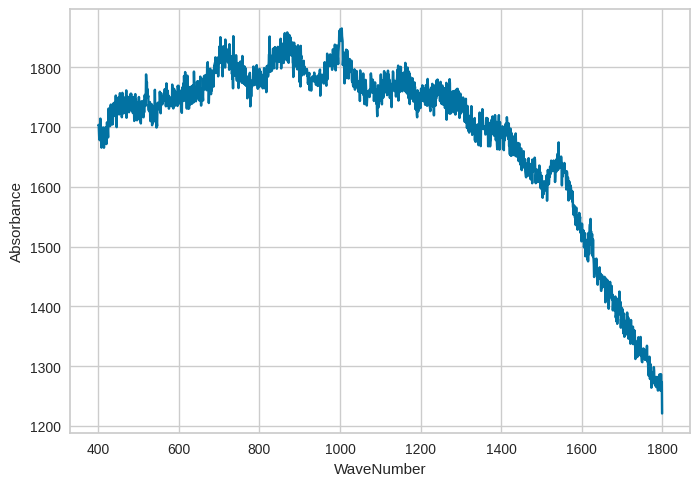

In [42]:
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

In [43]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    # Include the SurID to perform GroupKFold CV
    statuses_and_surface = df[['SpecID', 'SurID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses_and_surface, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

Pivot the Dataframe to create a column for each wavelength

In [46]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [47]:
wavelength_df.head()

,400.22778,400.91116,401.59454,402.27789,402.96127,403.64465,404.32803,405.01138,405.69476,406.37814,...,1794.9886,1795.672,1796.3553,1797.0387,1797.722,1798.4055,1799.0889,1799.7722,SurID,Status
SpecID,,,,,,,,,,,,,,,,,,,,,
201210-1-00,1765.6628,1774.7809,1769.0302,1756.4220,1758.8690,1763.2300,1745.2285,1773.3534,1774.7166,1753.3281,...,1210.4993,1213.9619,1225.2153,1210.0010,1210.6858,1194.4679,1195.1451,1189.8683,201210-1,Normal
201210-1-01,1966.9930,1962.4237,1954.5616,1954.3228,1963.0917,1975.0807,1979.3162,1963.4561,1968.4587,1964.0000,...,1382.6973,1363.7004,1360.6210,1354.0477,1353.0381,1353.9978,1361.2426,1370.2874,201210-1,Normal
201210-1-02,2182.6694,2149.6565,2146.0227,2159.3459,2167.2910,2160.9861,2145.6575,2134.2004,2142.8303,2138.6309,...,1976.2070,1989.0183,1996.2838,1979.3507,1976.2002,1994.9839,1974.2030,1971.1880,201210-1,Normal
201210-1-03,2445.0837,2430.4973,2422.7927,2434.3433,2454.9700,2462.8245,2454.7007,2467.7329,2449.5161,2421.3474,...,1992.3817,2022.6331,2001.8311,2010.0946,2006.4933,2017.2891,2038.1699,2000.6475,201210-1,Normal
201210-1-04,2250.4536,2248.6235,2245.0984,2242.7173,2235.2803,2228.9585,2236.0095,2229.6091,2225.9231,2211.0359,...,2009.0385,1953.3303,1963.5698,1964.5299,1969.5634,1986.6266,1970.1484,2007.0848,201210-1,Normal


##### PyCaret

In [49]:
import pandas as pd
from pycaret.classification import *

Set up the PyCaret environment

**Use GroupKFold to ensure that spectra from the same Surface are not used in both the training and testing folds.**

In [52]:
caret = setup(data=wavelength_df, target='Status', session_id=1234, fold_strategy='groupkfold', fold_groups='SurID')

,Description,Value
0,Session id,1234
1,Target,Status
2,Target type,Multiclass
3,Target mapping,"Hyperglycemia: 0, Hypoglycemia: 1, Normal: 2"
4,Original data shape,"(3045, 2051)"
5,Transformed data shape,"(3045, 2051)"
6,Transformed train set shape,"(2131, 2051)"
7,Transformed test set shape,"(914, 2051)"
8,Numeric features,2049
9,Categorical features,1


Compare models

In [53]:
compare_models(exclude=['lightgbm', 'gbc'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.5270,0.0000,0.5270,0.6701,0.5629,0.2826,0.3111,8.2500
rf,Random Forest Classifier,0.5018,0.0000,0.5018,0.6266,0.5208,0.2204,0.2389,1.1330
et,Extra Trees Classifier,0.4979,0.0000,0.4979,0.6181,0.5190,0.2178,0.2345,0.6990
knn,K Neighbors Classifier,0.4661,0.0000,0.4661,0.5651,0.4861,0.1686,0.1817,0.5310
nb,Naive Bayes,0.4610,0.0000,0.4610,0.5789,0.4370,0.1879,0.2331,0.4600
ridge,Ridge Classifier,0.3650,0.0000,0.3650,0.4847,0.4056,0.0455,0.0502,0.5300
svm,SVM - Linear Kernel,0.3576,0.0000,0.3576,0.5384,0.3483,0.1351,0.1864,0.6710
qda,Quadratic Discriminant Analysis,0.3516,0.0000,0.3516,0.3295,0.3033,0.0051,0.0047,0.8300
dt,Decision Tree Classifier,0.3495,0.0000,0.3495,0.1426,0.1984,0.0000,0.0000,0.5370
ada,Ada Boost Classifier,0.3495,0.0000,0.3495,0.1426,0.1984,0.0000,0.0000,3.7630


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Create the model

In [54]:
model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4313,0.0000,0.4313,0.4630,0.4326,0.1292,0.1335
1,0.5024,0.0000,0.5024,0.6670,0.5730,0.2010,0.2189
2,0.3318,0.0000,0.3318,0.5687,0.3751,0.0759,0.0901
3,0.4722,0.0000,0.4722,0.6751,0.4209,0.0585,0.0783
4,0.5498,0.0000,0.5498,0.7524,0.6340,0.2467,0.2754
5,0.5498,0.0000,0.5498,0.5661,0.5513,0.3215,0.3259
6,0.3602,0.0000,0.3602,0.3791,0.3331,0.0719,0.0785
7,0.7339,0.0000,0.7339,0.7945,0.7606,0.5359,0.5416
8,0.4692,0.0000,0.4692,0.5308,0.4727,0.2120,0.2257


In [55]:
tuned_model = tune_model(model)
#tuned_model = tune_model(model, n_iter=10, search_library='optuna')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.4313,0.0000,0.4313,0.4371,0.4337,0.0662,0.0663
1,0.4834,0.0000,0.4834,0.6122,0.5385,0.1433,0.1531
2,0.3773,0.0000,0.3773,0.5301,0.4117,0.1040,0.1149
3,0.4583,0.0000,0.4583,0.6335,0.4525,0.0708,0.0861
4,0.5403,0.0000,0.5403,0.7463,0.6241,0.2348,0.2626
5,0.5355,0.0000,0.5355,0.5428,0.5324,0.2974,0.3005
6,0.3555,0.0000,0.3555,0.3393,0.3185,0.0588,0.0635
7,0.7018,0.0000,0.7018,0.7543,0.7256,0.4804,0.4844
8,0.4645,0.0000,0.4645,0.5115,0.4577,0.2062,0.2208


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [56]:
evaluate_model(tuned_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…